In [1]:
%pylab inline
from scipy import ndimage
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable

import sys
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
import matplotlib.gridspec as gridspec
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_scalebar.scalebar import IMPERIAL_LENGTH
sys.path.append('../../')
from tractionforce.elasticity import *
import gc
from tractionforce.norms import *
from tractionforce.norms import *
from tractionforce.problem import *
from joblib import Parallel, delayed
import multiprocessing
import pickle
import gzip

from PIL import Image


def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str
    
def extractn(inlist,n):
    try:
        return inlist[n]
    except:
        return None

Populating the interactive namespace from numpy and matplotlib


In [2]:
padresults_x = pickle.load(gzip.open('results/pads_x.gz', 'rb'))
padresults_y = pickle.load(gzip.open('results/pads_y.gz', 'rb'))
#annulusresults_0 = pickle.load(gzip.open('results/annulus_1.gz','rb'))
annulusresults_x = pickle.load(gzip.open('results/annulus_x.gz','rb'))
annulusresults_y = pickle.load(gzip.open('results/annulus_y.gz','rb'))

pad_results = [ padresults_x,padresults_y]
annulus_results = [annulusresults_x,annulusresults_y]


pad_im = Image.open('padmask.tif')
pad_imarray = np.flip(np.array(pad_im),0)

annulus_im = Image.open('annulusmask.tif')
annulus_imarray = np.flip(np.array(annulus_im),0)

annulus_mask = annulus_imarray == 0
annulus_distance = -ndimage.distance_transform_edt(annulus_mask) + ndimage.distance_transform_edt(1 - annulus_mask)
annulus_distance = annulus_distance.flatten()

pad_mask = pad_imarray == 0
pad_distance = -ndimage.distance_transform_edt(pad_mask) + ndimage.distance_transform_edt(1 - pad_mask)
pad_distance = pad_distance.flatten()

N = 160
M = 120


In [3]:
# generate annulus stress
x_forward_positions = np.arange(N)
y_forward_positions = np.arange(M)

dx = abs(x_forward_positions[1]-x_forward_positions[0])
dy = abs(y_forward_positions[1]-y_forward_positions[0])

forward_coords = [[ [x,y] for x in x_forward_positions] for y in y_forward_positions] 
forward_coords = np.array([item for sublist in forward_coords for item in sublist])

distances = ((forward_coords[:,0]-N/2.)**2 + (forward_coords[:,1]-M/2.)**2)**0.5
angles = np.arctan2(forward_coords[:,1]-M/2.,forward_coords[:,0]-N/2.)

a = 22
b = 25 # stress support
_FORWARD_CUT_OFF = 40
_CUTOFF  = 10

fr = 1e-4
ftheta = 2e-4

m = 3
n = 5

condition_outside = (annulus_imarray.reshape((M*N,)) != 0 ) * (distances <= b + _FORWARD_CUT_OFF)
condition_inside = (annulus_imarray.reshape((M*N,)) == 0 ) * (distances >= a - _FORWARD_CUT_OFF)

stress_r = 0 + (distances>=a) * (distances<=b) * fr * np.sin(m*angles)
stress_theta = 0 + (distances>=a) * (distances<=b) * ftheta * np.cos(n*angles)

stress_x = stress_r*cos(angles) -stress_theta*sin(angles)
stress_y = stress_r*sin(angles) + stress_theta*cos(angles)

s_x = stress_x[condition_inside]
s_y = stress_y[condition_inside]

# build the stress field

x_out = np.array(forward_coords[condition_outside,0]/dx,dtype=int)
y_out = np.array(forward_coords[condition_outside,1]/dy,dtype=int)

x_in = np.array(forward_coords[condition_inside,0]/dx,dtype=int)
y_in = np.array(forward_coords[condition_inside,1]/dy,dtype=int)

annulus_x = stress_x.reshape((M,N))
annulus_y = stress_y.reshape((M,N))

In [4]:
x_forward_positions = np.arange(N)
y_forward_positions = np.arange(M)

dx = abs(x_forward_positions[1]-x_forward_positions[0])
dy = abs(y_forward_positions[1]-y_forward_positions[0])

forward_coords = [[ [x,y] for x in x_forward_positions] for y in y_forward_positions] 
forward_coords = np.array([item for sublist in forward_coords for item in sublist])

scaling = 25


r1 = 1.0/5*scaling
r2 = 1.0/6*scaling
r3 = 1.0/8*scaling
r4 = 1.0/4*scaling

c1 = np.array((-1,-1/2.))
c2 = np.array((0,-1))
c3 = np.array((2,1))
c4 = np.array((0,1))



d1 = ((forward_coords[:,0]-N/2.-c1[0]*scaling)**2 + (forward_coords[:,1]-M/2-c1[1]*scaling)**2)**0.5 # already up-scaled
d2 = ((forward_coords[:,0]-N/2.-c2[0]*scaling)**2 + (forward_coords[:,1]-M/2-c2[1]*scaling)**2)**0.5
d3 = ((forward_coords[:,0]-N/2.-c3[0]*scaling)**2 + (forward_coords[:,1]-M/2-c3[1]*scaling)**2)**0.5
d4 = ((forward_coords[:,0]-N/2.-c4[0]*scaling)**2 + (forward_coords[:,1]-M/2-c4[1]*scaling)**2)**0.5

A1 = np.pi * r1**2
A2 = np.pi * r2**2
A3 = np.pi * r3**2
A4 = np.pi * r4**2

a12 = 1e-4
a23 = 2e-4
g4 = 9e-5

G4 = g4*pi*(r4)**2/3.

s1_x = a12
s1_y = -a12/2.

s2_x = -a12*A1/A2 + a23
s2_y = G4/A2+a12*A1/A2/2. + a23

s3_x = -G4/A3 - a23*A2/A3
s3_y = -a23*A2/A3


in_1 = d1<=r1 
in_2 = d2<=r2 
in_3 = d3<=r3 
in_4 = d4<=r4 

stress_x = np.zeros(forward_coords.shape[0])
stress_y = np.zeros(forward_coords.shape[0])

stress_x[in_1] = s1_x * A1/sum(in_1)
stress_y[in_1] = s1_y * A1/sum(in_1)


stress_x[in_2] = s2_x * A2/sum(in_2)
stress_y[in_2] = s2_y * A2/sum(in_2)

stress_x[in_3] = s3_x * A3/sum(in_3)
stress_y[in_3] = s3_y * A3/sum(in_3)

stress_x[in_4] = g4*(1-d4[in_4]/r4)
stress_y[in_4] = -g4*(1-d4[in_4]/r4)

stress_x[in_4] *= G4/sum(stress_x[in_4])
stress_y[in_4] *= -G4/sum(stress_y[in_4])

# add the cone for region 4

pad_x = stress_x.reshape((M,N))
pad_y = stress_y.reshape((M,N))

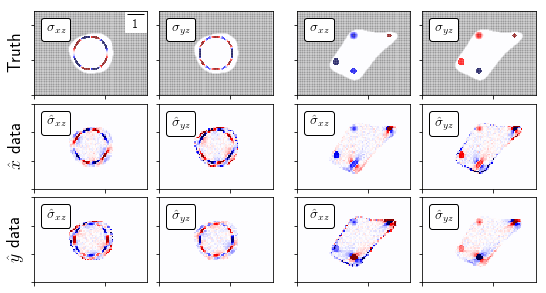

In [5]:
fig = plt.figure(figsize=(9,5))
#fig = plt.figure()
max_annulus = 1e-4
max_pads = 1e-4
gs0 = gridspec.GridSpec(1,2, hspace = 0.1,wspace=0.1)

gs_j_left = [] # just collect these here
gs_j_right = [] # just collect these here
ax = []
im = []

# left panel: annulus

J = 2

left_panel = gridspec.GridSpecFromSubplotSpec(J+1,1,
                subplot_spec=gs0[0,0],
                hspace = 0.1,wspace=0.1)

gs_j_left += [gridspec.GridSpecFromSubplotSpec(1,2,
            subplot_spec=left_panel[0,0],
            width_ratios = [1,1], hspace = 0.1,wspace=0.1)]
            #height_ratios = [1,1,1,1,1,1,1])]
        
ax += [plt.Subplot(fig, gs_j_left[0][0,0])]

fig.add_subplot(ax[-1])

im += [ax[-1].pcolormesh(annulus_x,
                     cmap='seismic_r',vmax=max_annulus,vmin=-max_annulus).axes.set_aspect('equal')]
ax[-1].pcolormesh(annulus_imarray==0,
                           cmap='gray',alpha=0.05).axes.set_aspect('equal')
ax[-1].set_yticklabels([])
ax[-1].set_xticklabels([])
scalebar = ScaleBar(0.04,font_properties = {'size': 12, 'weight': 'bold'}) # 1 pixel = .001
scalebar.label_formatter = lambda value, unit: str(value)#+' pixels'
ax[-1].add_artist(scalebar)

at = AnchoredText("${\sigma}_{xz}$",
              prop=dict(size=14), frameon=True,
              loc=2,
              )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax[-1].add_artist(at)

ax += [plt.Subplot(fig, gs_j_left[0][0,1])]
fig.add_subplot(ax[-1])

ax[-1].pcolormesh(annulus_y,
                     cmap='seismic_r',vmax=max_annulus,vmin=-max_annulus).axes.set_aspect('equal')
ax[-1].pcolormesh(annulus_imarray==0,
                           cmap='gray',alpha=0.05).axes.set_aspect('equal')
ax[-1].set_yticklabels([])
ax[-1].set_xticklabels([])

at = AnchoredText("${\sigma}_{yz}$",
              prop=dict(size=14), frameon=True,
              loc=2,
              )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax[-1].add_artist(at)    
    
for j in range(J):
    # Find the index of the best reconstruction
    
    data_error = [extractn(res,2) for res in annulus_results[j]][:-1]

    reg_error = [extractn(res,3) for res in annulus_results[j]][:-1]
    lvals = [extractn(res,4) for res in annulus_results[j]][:-1]

    # kill all nones

    data_error = np.array([item for item in data_error if item is not None])
    reg_error = np.array([item for item in reg_error if item is not None])
    lvals = np.array([item for item in lvals if item is not None])
    
    l_curve_distances = ((reg_error[-1]-reg_error[0])* data_error -  \
                (data_error[-1]-data_error[0])*(reg_error)+data_error[-1]*reg_error[0]-reg_error[-1]*data_error[0])**2
    best = np.argsort(l_curve_distances)[-1]
    
    bestresult = annulus_results[j][best]
    best_s_vals_x = bestresult[0][0]
    best_s_vals_y = bestresult[0][1]
    
    xlattice = bestresult[0][2]
    ylattice = bestresult[0][2]
    
       
    ####### Now we need to reconstruct the stress fields on a 2d grid
    # this is a pain! Should have saved the data more intelligently!
    
    gs_j_left += [gridspec.GridSpecFromSubplotSpec(1,2,
                subplot_spec=left_panel[j+1,0],
                width_ratios = [1,1], hspace = 0.1,wspace=0.1)]
                #height_ratios = [1,1,1,1,1,1,1])]
        
    ax += [plt.Subplot(fig, gs_j_left[j+1][0,0])]
    fig.add_subplot(ax[-1])
    ax[-1].pcolormesh(best_s_vals_x,
                     cmap='seismic_r',vmax=max_annulus,vmin=-max_annulus).axes.set_aspect('equal')#, vmax=2e-4,vmin=-2e-4)
    ax[-1].set_yticklabels([])
    ax[-1].set_xticklabels([])
    
    at = AnchoredText("$\hat{\sigma}_{xz}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)
    
    ax += [plt.Subplot(fig, gs_j_left[j+1][0,1])]
    fig.add_subplot(ax[-1])
    ax[-1].pcolormesh(best_s_vals_y,
                     cmap='seismic_r',vmax=max_annulus,vmin=-max_annulus).axes.set_aspect('equal')
    ax[-1].set_yticklabels([])
    ax[-1].set_xticklabels([])
    
    at = AnchoredText("$\hat{\sigma}_{yz}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)

###############################################################################
# right panel: pads
###############################################################################

right_panel = gridspec.GridSpecFromSubplotSpec(J+1,1,
                subplot_spec=gs0[0,1],
                hspace = 0.1,wspace=0.1)

gs_j_right += [gridspec.GridSpecFromSubplotSpec(1,2,
                subplot_spec=right_panel[0,0],
                width_ratios = [1,1], hspace = 0.1,wspace=0.1)]

ax += [plt.Subplot(fig, gs_j_right[0][0,0])]
fig.add_subplot(ax[-1])
ax[-1].pcolormesh(pad_x,
                     cmap='seismic_r',vmax=max_annulus,vmin=-max_annulus).axes.set_aspect('equal')
ax[-1].pcolormesh(pad_imarray==0,
                           cmap='gray',alpha=0.05).axes.set_aspect('equal')
ax[-1].set_yticklabels([])
ax[-1].set_xticklabels([])

at = AnchoredText("${\sigma}_{xz}$",
              prop=dict(size=14), frameon=True,
              loc=2,
              )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax[-1].add_artist(at)

ax += [plt.Subplot(fig, gs_j_right[0][0,1])]
fig.add_subplot(ax[-1])
ax[-1].pcolormesh(pad_y,
                     cmap='seismic_r',vmax=max_annulus,vmin=-max_annulus).axes.set_aspect('equal')
ax[-1].pcolormesh(pad_imarray==0,
                           cmap='gray',alpha=0.05).axes.set_aspect('equal')
ax[-1].set_yticklabels([])
ax[-1].set_xticklabels([])

at = AnchoredText("${\sigma}_{yz}$",
              prop=dict(size=14), frameon=True,
              loc=2,
              )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
ax[-1].add_artist(at)

for j in range(J):
    
    data_error = [extractn(res,2) for res in pad_results[j]][:-1]

    reg_error = [extractn(res,3) for res in pad_results[j]][:-1]
    lvals = [extractn(res,4) for res in pad_results[j]][:-1]

    # kill all nones

    data_error = np.array([item for item in data_error if item is not None])
    reg_error = np.array([item for item in reg_error if item is not None])
    lvals = np.array([item for item in lvals if item is not None])
    
    l_curve_distances = ((reg_error[-1]-reg_error[0])* data_error -  \
                (data_error[-1]-data_error[0])*(reg_error)+data_error[-1]*reg_error[0]-reg_error[-1]*data_error[0])**2
    best = np.argsort(l_curve_distances)[-1]
    
    bestresult = pad_results[j][best]
    best_s_vals_x = bestresult[0][0]
    best_s_vals_y = bestresult[0][1]
    
    xlattice = bestresult[0][2]
    ylattice = bestresult[0][2]
    
    gs_j_right += [gridspec.GridSpecFromSubplotSpec(1,2,
                subplot_spec=right_panel[j+1,0],
                width_ratios = [1,1], hspace = 0.1,wspace=0.1)]
                #height_ratios = [1,1,1,1,1,1,1])]
        
    ax += [plt.Subplot(fig, gs_j_right[j+1][0,0])]
    fig.add_subplot(ax[-1])
    ax[-1].pcolormesh(best_s_vals_x,
                     cmap='seismic_r',vmax=max_annulus,vmin=-max_annulus).axes.set_aspect('equal')#
    ax[-1].set_yticklabels([])
    ax[-1].set_xticklabels([])
    
    at = AnchoredText("$\hat{\sigma}_{xz}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)
    
    ax += [plt.Subplot(fig, gs_j_right[j+1][0,1])]
    fig.add_subplot(ax[-1])
    ax[-1].pcolormesh(best_s_vals_y,
                     cmap='seismic_r',vmax=max_annulus,vmin=-max_annulus).axes.set_aspect('equal')#
    
    ax[-1].set_yticklabels([])
    ax[-1].set_xticklabels([])
    
    at = AnchoredText("$\hat{\sigma}_{yz}$",
                  prop=dict(size=14), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax[-1].add_artist(at)



# left annotation

ax[0].set_ylabel("Truth",fontsize=18)
ax[2].set_ylabel("$\hat{x}$ data",fontsize=18)
ax[4].set_ylabel("$\hat{y}$ data",fontsize=18)
# top annotation

plt.savefig("../figures/unidirectionfig.pdf",bbox_inches='tight', 
               transparent=True)   